In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from util_data import *
from util_hmm_variational_gibbs import *
from smc import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
## Dataset parameters
num_series = 1
T = 50
K = 4
D = 2
dt = 10
Boundary = 30
noise_ratio = 0.5

## Model Parameters
num_particles_rws = 50
mcmc_steps = 3
num_particles_smc = 50
NUM_HIDDEN = 128
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False

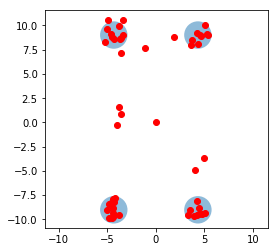

[[ 4.33659344  9.01076897]
 [ 4.33659344 -9.01076897]
 [-4.33659344 -9.01076897]
 [-4.33659344  9.01076897]]


In [3]:
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle

STATE, Disp, A_true, Zs_true = generate_seq(T, dt, Boundary, init_v, noise_cov)
## true global variables
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
Pi_true = np.ones(K) * (1/K)

plot_clusters(Disp, mu_true, cov_true, K)
Zs_true = torch.from_numpy(Zs_true).float()
cov_ks = torch.from_numpy(cov_true).float()
mu_ks = torch.from_numpy(mu_true).float()
Pi = torch.from_numpy(Pi_true).float()
A_init = torch.from_numpy(A_true).float()
## piror of A
alpha_trans_0 = initial_trans_prior(K)
## Y
Y = torch.from_numpy(Disp).float()
print(mu_true)

In [4]:
# A_samples = A_init
# Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
# Z_ret = resampling_smc(Zs, log_weights)
# plot_smc_sample(Zs_true, Z_ret)

In [5]:
## return samples in order to compute the weights and 
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior_sum, T):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden)).sum(0).view(K, K)
        latents_dirs_norm = latents_dirs / latents_dirs.sum() * (prior_sum + T-1)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs_norm[k]).sample()
        return latents_dirs_norm, A_samples

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [7]:
KLs = []
EUBOs = []
log_p_conds = []
log_qs = []
ESSs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
    v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
    init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
    T = np.random.randint(30, 50)
    STATE, Disp, A_true, Zs_true = generate_seq(T, dt, Boundary, init_v, noise_cov)
    ## true global variables
    cov_true = np.tile(noise_cov, (K, 1, 1))
    dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
    mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
    Pi_true = np.ones(K) * (1/K)
    cov_ks = torch.from_numpy(cov_true).float()
    mu_ks = torch.from_numpy(mu_true).float()
    Pi = torch.from_numpy(Pi_true).float()
    A_init = initial_trans(alpha_trans_0, K)
#     A_init = torch.from_numpy(A_true).float()
    alpha_trans_0 = initial_trans_prior(K)
    Y = torch.from_numpy(Disp).float()
    

    enc, loss_infer, eubo, kl, ess, latents_dirs, Z_ret = rws(enc, A_init, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws, num_particles_smc, mcmc_steps)
#     kl_est = torch.mul(weights_rws, log_p_conds - log_qs).sum().detach().item()
    log_q = - loss_infer
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo)
    ESSs.append(ess)
    log_qs.append(log_q)
    optimizer.step()
#     A_samples = A_samples.detach()
    time_end = time.time()
    print('epoch : %d, eubo : %f, log_q : %f, KL : %f (%ds)' % (epoch, eubo, log_q, kl, time_end - time_start))

epoch : 0, eubo : -298.273804, log_q : 9.448774, KL : 37.554684 (28s)
epoch : 1, eubo : -490.380280, log_q : 7.841568, KL : 44.095093 (35s)
epoch : 2, eubo : -261.754333, log_q : 12.575440, KL : 37.145733 (31s)
epoch : 3, eubo : -332.655853, log_q : 11.576880, KL : 40.200768 (35s)
epoch : 4, eubo : -571.242920, log_q : 9.155947, KL : 41.643127 (39s)
epoch : 5, eubo : -277.523865, log_q : 10.106085, KL : 32.591038 (28s)
epoch : 6, eubo : -366.486145, log_q : 6.913643, KL : 39.167252 (36s)
epoch : 7, eubo : -616.914185, log_q : 14.492699, KL : 48.515911 (38s)
epoch : 8, eubo : -448.479767, log_q : 8.628434, KL : 30.490988 (30s)
epoch : 9, eubo : -345.232086, log_q : 13.066997, KL : 31.915226 (32s)
epoch : 10, eubo : -370.199799, log_q : 9.582536, KL : 26.152922 (25s)
epoch : 11, eubo : -436.706696, log_q : 11.051342, KL : 38.898109 (36s)
epoch : 12, eubo : -348.371246, log_q : 10.074614, KL : 32.379608 (33s)
epoch : 13, eubo : -480.040161, log_q : 10.438270, KL : 32.218891 (33s)
epoch : 

variational : 
tensor([[17.7570,  2.1230,  1.1428,  2.3973],
        [ 2.2116,  7.9228,  1.9368,  1.1389],
        [ 1.2883,  1.9698, 15.0871,  1.8928],
        [ 2.4628,  1.0835,  2.5405, 10.0450]], grad_fn=<MulBackward>)
conjugate posterior :
tensor([[18.,  2.,  1.,  3.],
        [ 2.,  6.,  2.,  1.],
        [ 2.,  3., 18.,  1.],
        [ 1.,  1.,  3.,  9.]])


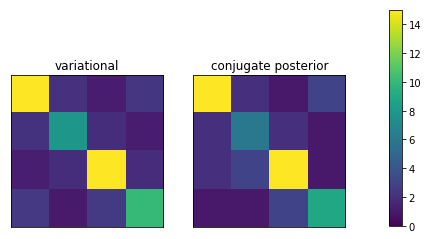

In [8]:
learned_dicichlet_post = latents_dirs
true_dirichlet_post = alpha_trans_0 + pairwise(torch.from_numpy(Zs_true).float(), T).sum(0)
print('variational : ')
print(learned_dicichlet_post)
print('conjugate posterior :')
print(true_dirichlet_post)
plot_dirs(learned_dicichlet_post.data.numpy(), true_dirichlet_post.data.numpy(), vmax=15)

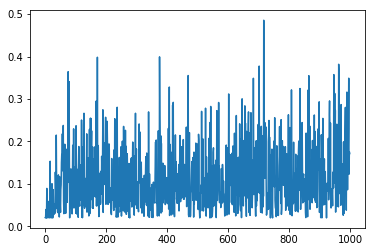

In [9]:
plt.plot(np.array(ESSs) / num_particles_rws)

In [10]:
learned_dicichlet_post.sum()

tensor(73., grad_fn=<SumBackward0>)